<font color="Green"><h1> **Intro to Deep Learning Final Project - Rice Classification**</h1></font>
<font color="Green"><h2> **Github Link**</h2></font>
<p><a href = "https://github.com/Connor-Crosslin/Deep-Learning-Final-Proj/blob/main/final-proj.ipynb">Github Link</a></p>

In [1]:
#import neccessary libraries and methods
from os import listdir
import cv2 
from matplotlib import pyplot as plt 
import numpy as np
import random
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras import layers, Sequential, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
import seaborn as sn
import pandas as pd

2024-06-19 01:05:02.927502: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 01:05:02.927646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 01:05:03.095604: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<font color="Green"><h2> **Data Provenance**</h2></font>
<p>The data comes from a set of researchers at University of Turkey who were doing a paper on rice varieties. Their goal was to evaluate seed quality of the rice using neural network algorithms. A link to the paper is in the reference list at the end of this notebook. From the paper the dataset was gathered as follows:
    
    "The study utilized datasets of five rice varieties commonly grown in Turkey, namely Arborio,Basmati, Ipsala, Jasmine, and Karacadag. The first dataset contained 75,000 rice grain images, with 15,000images from each variety[24]. The images in this dataset were RGB and had a size of 250 x 250 pixels, with each rice grain located within the image. In addition, a filter was applied to all images using MATLABenvironment to synthetically convert them into broken kernels, resulting in an additional 75,000 rice kernel images. The model used to convert intact rice kernels into broken ones was designed to produce images that closely resemble actual field scenarios. The original rice varieties used in the study, along with their corresponding broken kernels, are depicted in Fig. 2."

<font color="Green"><h2> **Problem Statement**</h2></font>
<p> The basic idea of this project will be to solve the obvious classification problem presented in the dataset but use three different models and perform a comparison of how each of them performed and try to explain variations in performance across different neural network models. The three models will be:
    
    1. K nearest neighbors
    2. A vanilla CNN model
    2. A capsule neural network (abbr. CapsNet)

The data is given in separate folders, luckily each file is named for the type of rice it is so we will not have to create a new .csv for labels, we can simply use the first letter of each file name as our label (we will verify that is the case in our EDA).

Once we have verefied the filenames are correct, we will go through and randomly sample images from each folder to creat our test and train datasets.

<font color="Green"><h2> **Exploratory Data Analysis**</h2></font>

In [2]:
#get raw images

Arborio_directory = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Arborio/"
Basmati_directory = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Basmati/"
Ipsala_directory = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Ipsala/"
Jasmine_directory = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Jasmine/"
Karacadag_directory = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset/Karacadag/"

Arborio_files = listdir(Arborio_directory)
Basmati_files = listdir(Basmati_directory)
Ipsala_files = listdir(Ipsala_directory)
Jasmine_files = listdir(Jasmine_directory)
Karacadag_files = listdir(Karacadag_directory)

Text(0.5, 1.0, 'Karacadag')

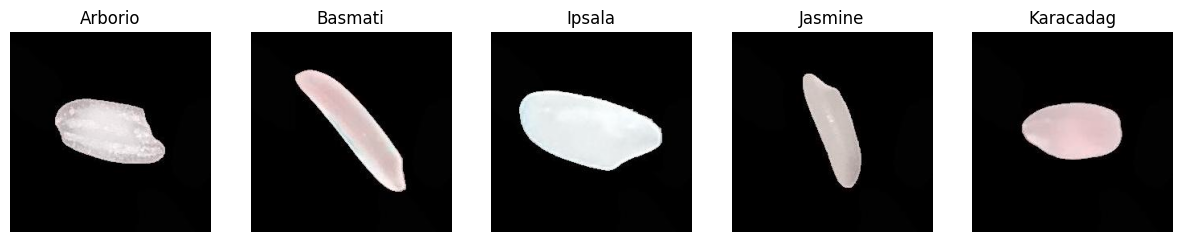

In [3]:
#rerun this cell to see random images

fig = plt.figure(figsize=(15, 15)) 
  
rows = 1
columns = 5

rand_int = np.random.randint(0, 14000)

Arborio_img = cv2.imread(Arborio_directory + Arborio_files[rand_int]) 
Basmati_img = cv2.imread(Basmati_directory + Basmati_files[rand_int]) 
Ipsala_img = cv2.imread(Ipsala_directory + Ipsala_files[rand_int]) 
Jasmine_img = cv2.imread(Jasmine_directory + Jasmine_files[rand_int]) 
Karacadag_img = cv2.imread(Karacadag_directory + Karacadag_files[rand_int])

fig.add_subplot(rows, columns, 1) 
  
plt.imshow(Arborio_img) 
plt.axis('off') 
plt.title("Arborio") 
  
fig.add_subplot(rows, columns, 2) 
  
plt.imshow(Basmati_img) 
plt.axis('off') 
plt.title("Basmati") 
  
fig.add_subplot(rows, columns, 3) 
  
plt.imshow(Ipsala_img) 
plt.axis('off') 
plt.title("Ipsala") 
  
fig.add_subplot(rows, columns, 4) 
  
plt.imshow(Jasmine_img) 
plt.axis('off') 
plt.title("Jasmine") 

fig.add_subplot(rows, columns, 5) 
  
plt.imshow(Karacadag_img) 
plt.axis('off') 
plt.title("Karacadag") 

In [4]:
#since we will be using the first letter in the filenames as our labels, lets verify there are no issues:

directory_strings = ["Arborio_directory", "Basmati_directory", "Ipsala_directory", "Jasmine_directory", "Karacadag_directory"]
files_list = [Arborio_files, Basmati_files, Ipsala_files, Jasmine_files, Karacadag_files]

i = 0
for directory in directory_strings:
    for file in files_list[i]:
        if file[0].lower() != directory[0].lower():
            print("Mismatch!", file[0].lower(), " ;",directory[0].lower() )
    i += 1

In [5]:
def color_getter(rice_type):
    
    blue = []
    green = []
    red = []

    for i in range(500):
        rand3 = random.randint(0, len(rice_type + "_files") - 1)
        
        #use 100, 149 tp get from center region of each image (avoid black border)
        
        randx = random.randint(100, 149)
        randy = random.randint(100, 149)
        
        path = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset/" + rice_type + "/"
        file_name = listdir(path)[rand3]
        image = Image.open(path + file_name)
        
        #getpixel returns values in order blue, green, red
        
        bgr_values = image.getpixel((randx, randy))
        blue.append(bgr_values[0])
        green.append(bgr_values[1])
        red.append(bgr_values[2])
    
    return blue, green, red

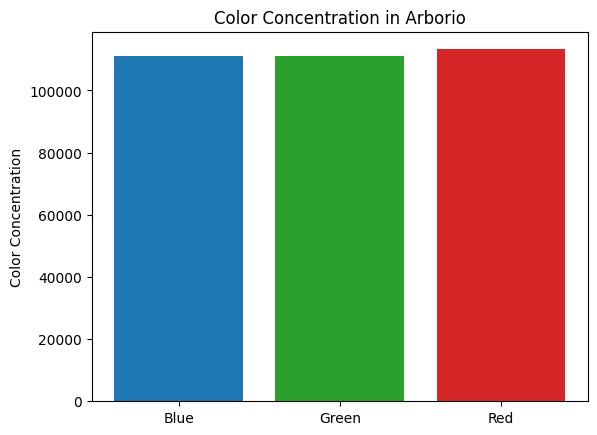

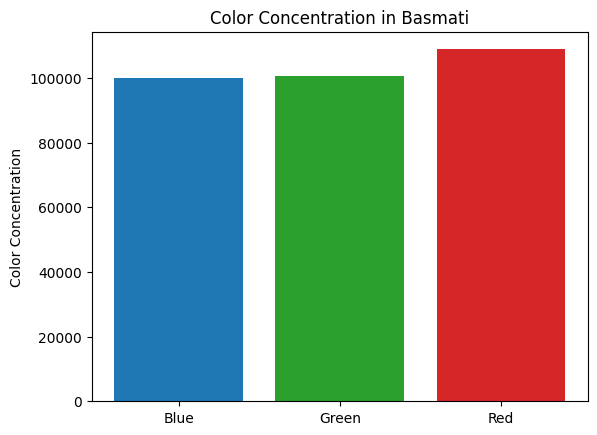

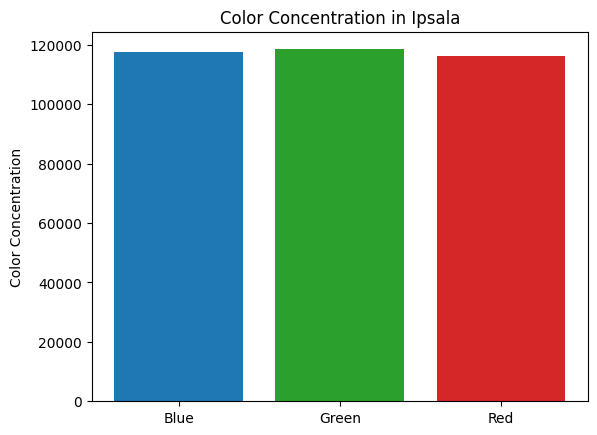

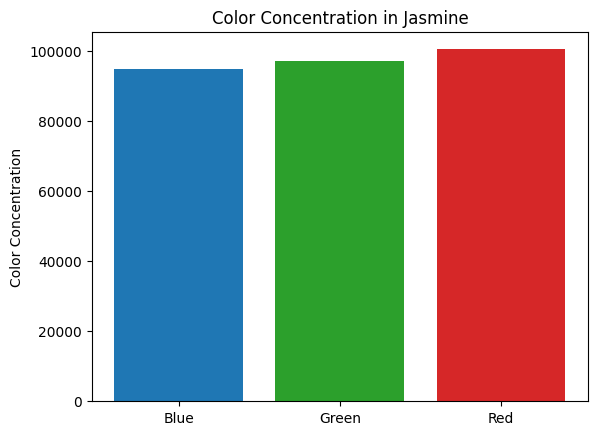

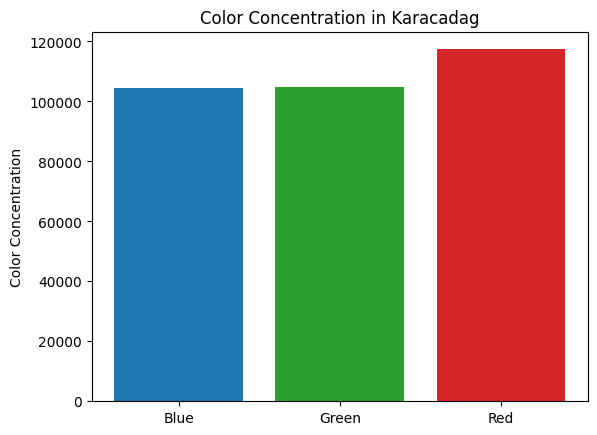

In [6]:
rice_type_strings = ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]

for rice_type in rice_type_strings:
    fig, ax = plt.subplots()
    
    blue, green, red = color_getter(rice_type)
    
    Colors = ['Blue', 'Green', 'Red']
    counts = [sum(blue), sum(green), sum(red)]
    bar_labels = ['blue', 'green', 'red']
    bar_colors = ['tab:blue', 'tab:green', 'tab:red']

    ax.bar(Colors, counts, label=bar_labels, color=bar_colors)

    ax.set_ylabel('Color Concentration')
    ax.set_title('Color Concentration in ' + rice_type)

    plt.show()

In [7]:
#now lets sample our data

random.seed(888)

#sample the test data
#get full list of files

directory_list = [Arborio_directory, Basmati_directory, Ipsala_directory, Jasmine_directory, Karacadag_directory]

i = 0
full_list = []
for directory in directory_list:
    for file in files_list[i]:
        full_list.append(directory + file)
    i += 1
    
np.random.shuffle(full_list)
train_size = 2500 #60000 if memory allows

X_train_paths = full_list[0:train_size]
test_index = train_size + 1 + int(train_size*2)
X_test_paths = full_list[train_size + 1: test_index] #15000 if memory allows

We will need to reassign the labels from strings to numbers like so:

| Label      | Number      |
| ------------- | ------------- |
| Arborio| 0 |
| Basmati | 1 |
| Ipsala | 2 |
| Jasmine | 3 |
| Karacadag | 4 |

In [8]:
Y_train = np.empty((train_size))
Y_test = np.empty(len(X_test_paths))
lookup_dict = {'a' : 0, 'b': 1, 'i': '2', 'j' : 3, 'k': 4}

i = 0
for path in X_train_paths:
    Y_train[i] = lookup_dict[path[52].lower()]
    i += 1
    
i = 0
for path in X_test_paths:
    Y_test[i] = lookup_dict[path[52].lower()]
    i += 1
    
del i

In [9]:
#convert our X paths to image arrays and rescale

X_train = np.empty((len(X_train_paths), 250, 250, 3))
i = 0
for path in X_train_paths:
    X_train[i] = cv2.imread(path)
    i += 1

X_train = X_train/255.0

X_test = np.empty((len(X_test_paths), 250, 250, 3))
i = 0
for path in X_test_paths:
    X_test[i] = cv2.imread(path)
    i += 1
    
X_test = X_test/255.0

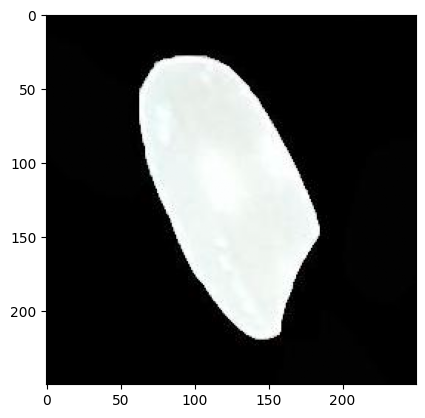

In [10]:
#double check to make sure we did the conversion correctly for train data

rand = random.randint(0, X_train.shape[0])
plt.imshow(X_train[rand])
plt.show()


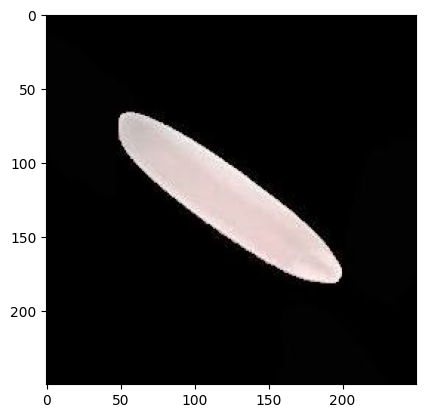

In [11]:
#double check to make sure we did the conversion correctly for test data

rand = random.randint(0, X_test.shape[0])
plt.imshow(X_test[rand])
plt.show()

<font color="Green"><h2> **Model Architecture (Build the Model)**</h2></font>
<p> We will build three models: random forest, vanilla CNN, and CapsNet neural network. The main problem is a classification one. 

In [12]:
#scikit knn expects 2d arrays as inputs, so we will give it 2d arrays

X_train_knn = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
X_test_knn = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3]))


In [13]:
#check and make sure our data is of the correct size
print(X_test_knn.shape)
print(X_train_knn.shape)

(5000, 187500)
(2500, 187500)


Basic sci-kit defeault model:

Number of neighbors by default is five, which works out nicely

Minkowski Distance: Generalization of Euclidean and Manhattan distance that can apply to dimensions higher than 2D (which is required for our vector space): $D(X, Y) = (\sum_{i=1}^{n}|x_i - y_i|^p)^{1/p}$ (Manhattan if $p = 1$, Euclidean if $p = 2$, Chebyshev if $p = \infty$)

Weights are uniform by default, meaning each neighborhoods weights are equal (no extra importance is given to any one cluster based on other variables)

In [14]:
#start with basic model

knnModel = KNeighborsClassifier(n_neighbors=5)
knnModel.fit(X_train_knn, Y_train)

KNeighborsClassifier()

In [15]:
#predict based on test set

knn_pred = knnModel.predict(X_test_knn)

[[911   0   0   6 101]
 [  0 987   0  43   0]
 [ 11   0 946   2   0]
 [  8  75   1 900   1]
 [ 21   0   0   0 987]]


<Axes: >

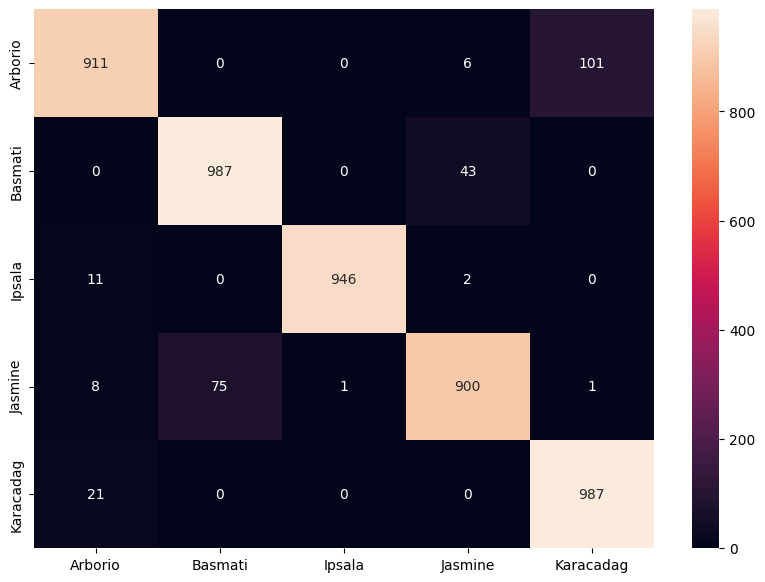

In [16]:
#output confision matrix

cm = confusion_matrix(Y_test, knn_pred)
print(cm)

df_cm = pd.DataFrame(cm.astype(int), index = [i for i in rice_type_strings], columns = [i for i in rice_type_strings])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt="d")

In [17]:
#basic default knn performed better than expected

In [18]:
#now lets try a vanilla CNN

vanilla_CNN1 = Sequential([
Conv2D(32, (3,3), activation = 'relu', input_shape = (250, 250, 3)),
MaxPooling2D((2,2)),
Conv2D(32, (3,3), activation = 'relu'),
MaxPooling2D((2,2)),
Flatten(),
Dense(64, activation = 'relu'),
Dense(5, activation = 'softmax')
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Why loss categorical crossentropy?

This is the standard for the multi-class classification problem we are solving. It is a variation cross entropy loss form which specific applications like binary and multiclass case are derived.

Cross-Entropy Loss: $-\sum_{i = 1}^{N} truey_i * log(predy_i)$ 


Why are we using Adam optimizer?

An extension of Stochastic Gradient Descent. "This algorithm is used to accelerate the gradient descent algorithm by taking into consideration the ‘exponentially weighted average’ of the gradients. Using averages makes the algorithm converge towards the minima in a faster pace." - GeeksforGeeks, link in reference list.

In [19]:
opt = optimizers.Adam(learning_rate = 0.001)
vanilla_CNN1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
#need to reshape our Y_train for the model input

temp = np.zeros((Y_train.shape[0], 5))
for y in range(Y_train.shape[0]):
    true_index = int(Y_train[y])
    temp[y][true_index] = 1

Y_train_CNN = temp

#and again for Y_test

temp = np.zeros((Y_test.shape[0], 5))
for y in range(Y_test.shape[0]):
    true_index = int(Y_test[y])
    temp[y][true_index] = 1

Y_test_CNN = temp

In [21]:
#just to make sure we didn't mess up our shapes

print(Y_train_CNN.shape)
print(Y_train_CNN[0:10])
print(Y_test_CNN.shape)
print(Y_test_CNN[0:10])

(2500, 5)
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]
(5000, 5)
[[0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]


In [22]:
vanilla_CNN1.fit(X_train, Y_train_CNN, batch_size= 250, epochs=10)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 96s 9s/step - accuracy: 0.4151 - loss: 1.3716
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 95s 9s/step - accuracy: 0.9069 - loss: 0.3873
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 110s 11s/step - accuracy: 0.9578 - loss: 0.1304
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 99s 10s/step - accuracy: 0.9823 - loss: 0.0547
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 95s 9s/step - accuracy: 0.9801 - loss: 0.0492
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 98s 10s/step - accuracy: 0.9917 - loss: 0.0332
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 105s 10s/step - accuracy: 0.9943 - loss: 0.0243
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 96s 9s/step - accuracy: 0.9979 - loss: 0.0124
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 97s 10s/step - accuracy: 0.9969 - loss: 0.0130
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 111s 11s/step - accuracy: 0.9976 - loss: 0.0094


In [23]:
CNN_eval = vanilla_CNN1.evaluate(X_test, Y_test_CNN)

157/157 ━━━━━━━━━━━━━━━━━━━━ 61s 390ms/step - accuracy: 0.9561 - loss: 0.1918


In [24]:
CNN_pred = vanilla_CNN1.predict(X_test)

157/157 ━━━━━━━━━━━━━━━━━━━━ 61s 388ms/step


In [25]:
CNN_pred = np.argmax (CNN_pred, axis = 1)

[[911   0   0   6 101]
 [  0 987   0  43   0]
 [ 11   0 946   2   0]
 [  8  75   1 900   1]
 [ 21   0   0   0 987]]


<Axes: >

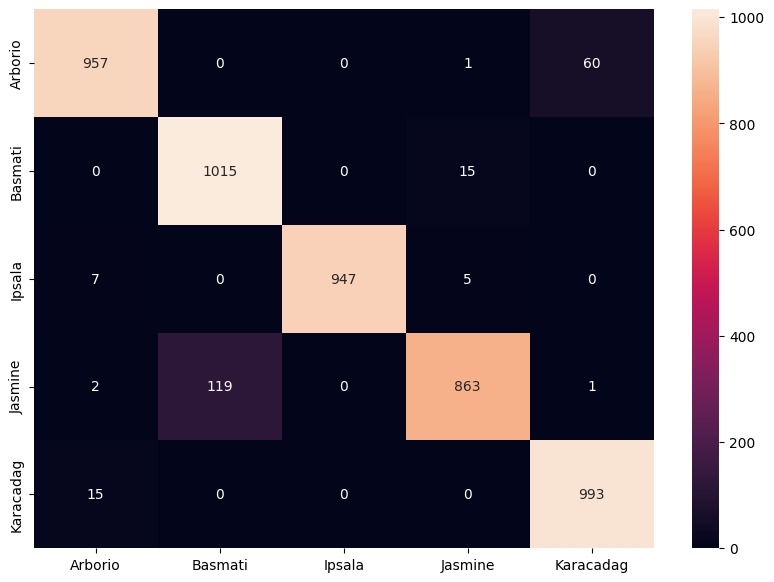

In [26]:
#output confision matrix

cm2 = confusion_matrix(Y_test, CNN_pred)
print(cm)

df_cm2 = pd.DataFrame(cm2.astype(int), index = [i for i in rice_type_strings], columns = [i for i in rice_type_strings])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm2, annot=True, fmt="d")

<font color="Green"><h2> **Discussion and Conclusion**</h2></font>
<p> Our vanilla models both performed relativley well. The reasoning for this is likely due to the nature of the datasets. The stark black and light contrast of the images probably lead to very obvious difference in the resulting image numpay array where different rice types have a similar number of high value entries in the array. From there, the slight variations in the color probably allow the machine learning models to classify effectively. This is supported by the fact that the issue that the models had were mostly on the two rice types which had similar shape: Kardacag and Arborio as well as Basmati and Jasmine. Overall the CNN performed better than the KNN and I believe with more processing power the CNN would be able to perform more accurately still. It may be difficult to find real-world applications of this model since the dataset it was trained on seems almost tailor made to ML algorithms. Most AI applications for agriculture are used to identify agircultural products in a real outdoor setting rather than controlled environments.

<font color="Green"><h2> **Reference List**</h2></font>
<p><a href="https://www.sciencedirect.com/science/article/abs/pii/S0168169921003021?via%3Dihub">Research Paper - "Classification of rice varieties with deep learning methods"<a>
<p><a href="https://www.geeksforgeeks.org/how-to-display-multiple-images-in-one-figure-correctly-in-matplotlib/#">Image Plot Tutorial<a>
<p><a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html">SKLearn K-neighbors Documentation<a>   
<p><a href="https://www.geeksforgeeks.org/adam-optimizer/#">Geeks for Geeks article on Adam Optimizer</a></p>
<p><a href="https://www.ijmcer.com/wp-content/uploads/2023/07/IJMCER_B05301523.pdf">Original Research Paper for the Rice Dataset</a></p>
